In [1]:
from IPython.display import display
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  

def visualize(texts, features, document_feature_frequencies):
    m = pd.DataFrame(columns=['text']+features)
    for text_index, text in enumerate(texts):
        row = {'text': text}
        for feature_index, feature in enumerate(features):
            row[feature] = document_feature_frequencies[text_index, feature_index]
        m = m.append(row, ignore_index=True)
    
    plt.figure(figsize=(12, 3))
    plt.title('Documents vs. feature weights')
    sns.heatmap(
        m[features].astype('float'), 
        annot=True,
        linewidths=.5, 
        cmap='Oranges', 
        yticklabels=m['text'])
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()
    
    from sklearn.metrics.pairwise import cosine_similarity
    
    document_similarities = cosine_similarity(document_feature_frequencies, document_feature_frequencies)
    plt.figure(figsize=(12, 3))
    plt.title('Document similarities')
    sns.heatmap(
        document_similarities, 
        annot=True,
        linewidths=.5, 
        cmap='Oranges', 
        xticklabels=m['text'], 
        yticklabels=m['text'])
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()
    
    feature_document_frequencies = np.transpose(document_feature_frequencies)
    feature_similarities = cosine_similarity(feature_document_frequencies, feature_document_frequencies)
    plt.figure(figsize=(12, 6))
    plt.title('Feature similarities')
    sns.heatmap(
        feature_similarities, 
        annot=True,
        linewidths=.5, 
        cmap='Oranges', 
        xticklabels=features, 
        yticklabels=features)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

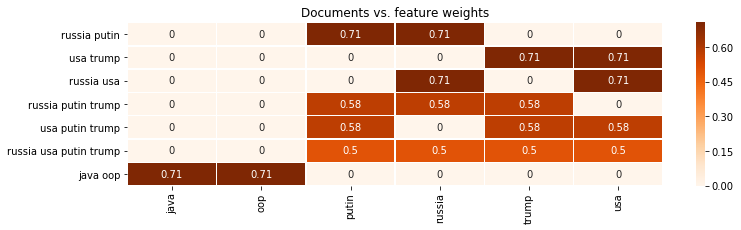

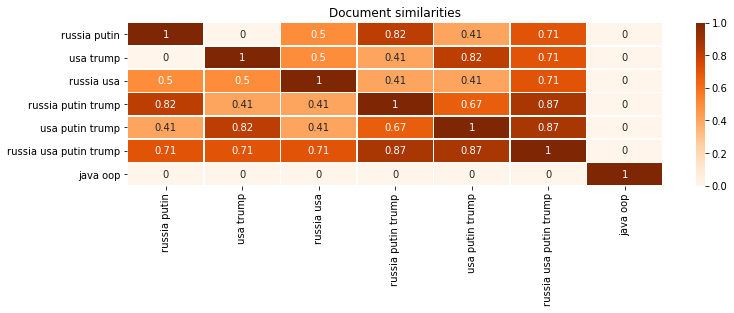

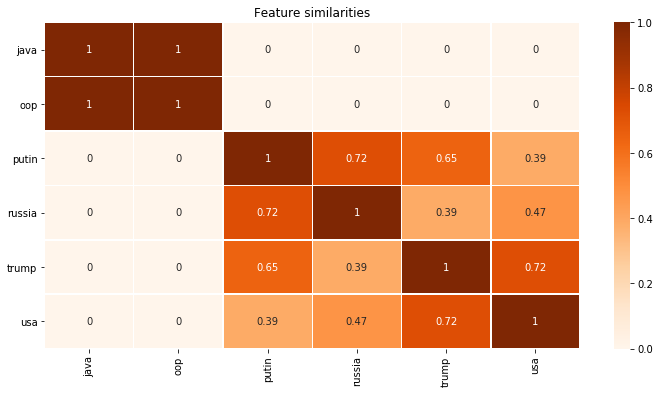

In [2]:
documents = pd.DataFrame([
    {'text': 'russia putin', 'category': 'russia'},
    {'text': 'usa trump', 'category': 'usa'},
    {'text': 'russia usa', 'category': 'world'},
    {'text': 'russia putin trump', 'category': 'world'},
    {'text': 'usa putin trump', 'category': 'world'},
    {'text': 'russia usa putin trump', 'category': 'world'},
    {'text': 'java oop', 'category': 'programming'}
])

tfidf_vectorizer = TfidfVectorizer()
frequencies = tfidf_vectorizer.fit_transform(documents['text'])
features = tfidf_vectorizer.get_feature_names()
visualize(documents['text'], features, frequencies)

In [3]:
from sklearn.preprocessing import LabelEncoder
category_encoder = LabelEncoder()
category_encoder.fit(documents['category'].unique().tolist())
encoded_categories = category_encoder.transform(documents['category'])

from sklearn.naive_bayes import GaussianNB
naive_bayes = GaussianNB()
naive_bayes.fit(
    frequencies.toarray(), 
    encoded_categories)

predicted_encoded_categories = naive_bayes.predict(frequencies.toarray())

predicted_decoded_categories = category_encoder.inverse_transform(predicted_encoded_categories)
print(predicted_decoded_categories)
print(naive_bayes.predict_log_proba(frequencies.toarray()))
print(naive_bayes.predict_proba(frequencies.toarray()))

['russia' 'usa' 'world' 'world' 'world' 'world' 'programming']
[[-1.00503687e+10  0.00000000e+00 -1.00503687e+10 -4.32710244e+01]
 [-1.00503687e+10 -1.00503687e+10  0.00000000e+00 -4.32710244e+01]
 [-1.00503687e+10 -5.02518433e+09 -5.02518433e+09  0.00000000e+00]
 [-1.00503687e+10 -1.84427699e+09 -5.94732284e+09  0.00000000e+00]
 [-1.00503687e+10 -5.94732284e+09 -1.84427699e+09  0.00000000e+00]
 [-1.00503687e+10 -2.94368481e+09 -2.94368481e+09  0.00000000e+00]
 [ 0.00000000e+00 -1.00503687e+10 -1.00503687e+10 -5.02518442e+09]]
[[0.00000000e+00 1.00000000e+00 0.00000000e+00 1.61299451e-19]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 1.61299451e-19]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]


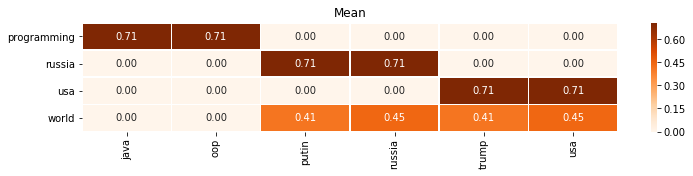

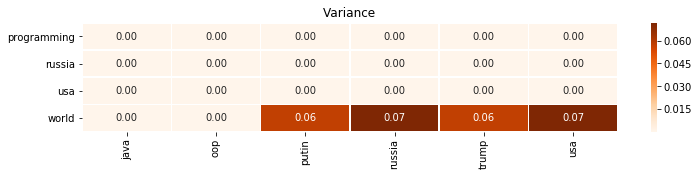

In [4]:
plt.figure(figsize=(12, 2))
plt.title('Mean')
sns.heatmap(
    naive_bayes.theta_, 
    annot=True,
    #annot_kws={'rotation': 90},
    fmt='.2f',
    linewidths=.5, 
    cmap='Oranges', 
    xticklabels=features,
    yticklabels=category_encoder.classes_)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

plt.figure(figsize=(12, 2))
plt.title('Variance')
sns.heatmap(
    naive_bayes.sigma_, 
    annot=True,
    #annot_kws={'rotation': 90},
    fmt='.2f',
    linewidths=.5, 
    cmap='Oranges', 
    xticklabels=features,
    yticklabels=category_encoder.classes_)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

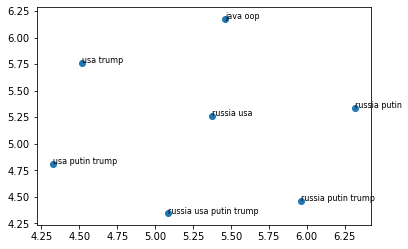

In [5]:
from umap import UMAP
import warnings # umap prints lots of warnings
warnings.filterwarnings('ignore')

embedding = UMAP().fit_transform(frequencies)

fig, ax = plt.subplots()
ax.scatter(embedding[:, 0], embedding[:, 1])

for i, txt in enumerate(documents['text']):
    ax.annotate(txt, (embedding[i, 0], embedding[i, 1]), fontsize=8)

In [10]:
from sklearn.decomposition import LatentDirichletAllocation

for number_of_topics in [2, 3, 4]:
    lda = LatentDirichletAllocation(n_components=number_of_topics)
    document_topic_probability_matrix = lda.fit_transform(frequencies)

    print(f'\n{number_of_topics} topics:')
    
    min_probability_to_consider_assigned_to_topic = 0.6
    
    number_of_features = lda.components_.shape[1]
    for topic_index in range(number_of_topics):
        topic_features = lda.components_[topic_index]
        sorted_feature_indexes = np.argsort(topic_features)[::-1]
        
        print(
            f'  Topic #{topic_index}:', 
            ' + '.join([f'"{features[i]}" x {topic_features[i]:.2f}' for i in sorted_feature_indexes]))        
        
        for document_index, document in enumerate(documents['text']):
            document_topic_probability_row = document_topic_probability_matrix[document_index]  
            if document_topic_probability_row[topic_index] >= min_probability_to_consider_assigned_to_topic:
                print(f'    "{document}"')
                
    print('  No topic:')
    for document_index, document in enumerate(documents['text']):
        document_topic_probability_row = document_topic_probability_matrix[document_index]
        has_topic = False
        for topic_index in range(number_of_topics):
            if document_topic_probability_row[topic_index] >= min_probability_to_consider_assigned_to_topic:
                has_topic = True
                break
        if has_topic:
            continue
        print(f'    "{document}"')


2 topics:
  Topic #0: "usa" x 2.94 + "russia" x 2.94 + "trump" x 2.81 + "putin" x 2.81 + "java" x 0.50 + "oop" x 0.50
    "russia putin"
    "usa trump"
    "russia usa"
    "russia putin trump"
    "usa putin trump"
    "russia usa putin trump"
  Topic #1: "oop" x 1.20 + "java" x 1.20 + "russia" x 0.55 + "usa" x 0.55 + "putin" x 0.55 + "trump" x 0.55
    "java oop"
  No topic:

3 topics:
  Topic #0: "usa" x 0.35 + "russia" x 0.35 + "trump" x 0.34 + "putin" x 0.34 + "java" x 0.34 + "oop" x 0.34
  Topic #1: "oop" x 1.04 + "java" x 1.04 + "usa" x 0.34 + "russia" x 0.34 + "trump" x 0.34 + "putin" x 0.34
    "java oop"
  Topic #2: "russia" x 2.81 + "usa" x 2.81 + "putin" x 2.68 + "trump" x 2.68 + "oop" x 0.33 + "java" x 0.33
    "russia putin"
    "usa trump"
    "russia usa"
    "russia putin trump"
    "usa putin trump"
    "russia usa putin trump"
  No topic:

4 topics:
  Topic #0: "putin" x 1.55 + "russia" x 1.52 + "oop" x 0.96 + "java" x 0.96 + "trump" x 0.78 + "usa" x 0.25
    "russ